You probably need around >=25GB for a session with ~4800 ROIs and a FOV=(512,1024)

# ROI Registration across sessions

### Steps:

#### 1. Import files:
    - Currently expecting S2p stuff. Imports stat.npy and ops.npy files 
#### 2. Formatting
    - converts raw files to lists of spatial footprints: (each spatial footprint is a single ROI in an entire FOV)
#### 3. Align FOVs
    - uses non-rigid alignment (cv2.calcOpticalFlowFarneback) to build a flow field
#### 4. Makes batches of FOV blocks
    - each block has an 'inner' and 'outer' block
#### 5. Main loop: 
    a. extacts spatial footprints from all ROIs in all sessions within one block at a time 
    b. performs nearest neighbors search and makes kNN graph (GPU optional) 
    c. performs t-SNE using the kNN graph to get 2-D embeddings 
    d. stores results for each block 
#### 6. Cluster ROIs: 
    a. User first checks out a few blocks and manually tunes epsilon parameter to a desired value 
    b. User inputs desired epsilon value and it is used for all blocks
#### 7. Score Clusters: 
    a. Define some user specified parameters for different quality metrics: (cluster_size, distance_mean, distance_std, etc.) 
    b. Go through each cluster in each block and score each metric 
    c. Threshold clusters to find which clusters in which blocks meet criteria
#### 8. Assign ROIs to clusters 
    a. Currently doing a greedy method: a random ROI that meets inclusion criteria (IC) is chosen, it randomly chooses a cluster that it is in that meets IC, then removes all other ROIs in that cluster from the pool to choose next ROI from. 
    b. Outputs are Unique Cluster IDs (UCIDs) for each ROI across sessions.
    

In [2]:
# widen jupyter notebook window
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

# check environment
import os
print(f'Conda Environment: ' + os.environ['CONDA_DEFAULT_ENV'])

Conda Environment: rapids-21.12


In [3]:
from pathlib import Path
import scipy.io
import scipy.sparse
import matplotlib.pyplot as plt
import numpy as np
import sklearn.manifold
import sklearn.cluster
import seaborn as sns
import pandas as pd
import sparse
import cv2


import gc
from tqdm.notebook import tqdm
import copy
import time
import random

In [4]:
# only needed if using cuml's TSNE instead of sklearn's
pref_useCuml = True

if pref_useCuml:
    import cuml
    import cuml.manifold

In [5]:
import sys
# sys.path.append("/n/data1/hms/neurobio/sabatini/rich/github_repos/")
sys.path.append("/media/rich/Home_Linux_partition/github_repos/")

%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import *

In [6]:
# dir_allOuterFolders = Path("/n/data1/hms/neurobio/sabatini/rich/data/res2p/round_5_experiments/mouse_2_6/scanimage/")
dir_allOuterFolders = Path("/media/rich/bigSSD/res2p/scanimage data/round 5 experiments/mouse 2_6/just_stat_files")
pathSuffixToStat = "stat.npy"
pathSuffixToOps = "ops.npy"

paths_allOuterFolders, pathContents, pathNumerics = path_helpers.get_numeric_contents(dir_allOuterFolders, sort=True)

paths_allOuterFolders = paths_allOuterFolders[1:-1]
pathContents = pathContents[1:-1]
pathNumerics = pathNumerics[1:-1]

# paths_allOuterFolders = paths_allOuterFolders[2:3]
# pathContents = pathContents[2:3]
# pathNumerics = pathNumerics[2:3]

In [8]:
paths_allStat = [path / pathSuffixToStat for path in paths_allOuterFolders]

## Make spatial_footprints
Make a lazy list of all the spatial_footprints

In [10]:
sf_all = ca2p_preprocessing.import_and_convert_to_CellReg_spatialFootprints(paths_allStat, frame_height=512, frame_width=1024)

## Save spatial_footprints as sparse matrices
I hate this code, but it's necessary to remain low(ish) memory when saving

In [12]:
def register_FOVs(templateFOV, FOVs):
    dims = templateFOV.shape
    x_grid, y_grid = np.meshgrid(np.arange(0., dims[1]).astype(np.float32), np.arange(0., dims[0]).astype(np.float32))

    template_norm = np.uint8(templateFOV * (templateFOV > 0) * 0.25)
    FOVs_norm = [np.uint8(FOVs[ii] * (FOVs[ii] > 0) * 0.25) for ii in range(len(FOVs))]
    
    for ii in range(len(FOVs)):
#         FOV_norm = np.uint8(FOVs_norm[ii] * (FOVs_norm[ii] > 0) * 255)
        flow = cv2.calcOpticalFlowFarneback(template_norm, FOVs_norm[ii], None,
                                            0.5, 3, 128, 3, 7, 1.5, 0)
        x_remap = (flow[:, :, 0] + x_grid).astype(np.float32)
        y_remap = (flow[:, :, 1] + y_grid).astype(np.float32)

        # A_2t = np.reshape(A2, dims + (-1,), order='F').transpose(2, 0, 1)
#         A_2t = sf_all[6]
        FOV_aligned = cv2.remap(FOVs_norm[ii], x_remap, y_remap, cv2.INTER_NEAREST)
        # A2 = np.reshape(A2.transpose(1, 2, 0), (A1.shape[0], A_2t.shape[0]), order='F')
                
        yield FOV_aligned

In [13]:
def register_ROIs(templateFOV, FOVs, ROIs, return_sparse=False, normalize=True):
    dims = templateFOV.shape
    x_grid, y_grid = np.meshgrid(np.arange(0., dims[1]).astype(np.float32), np.arange(0., dims[0]).astype(np.float32))

    template_norm = np.uint8(templateFOV * (templateFOV > 0) * 255)
    FOVs_norm    = [np.uint8(FOVs[ii] * (FOVs[ii] > 0) * 255) for ii in range(len(FOVs))]

    
    for ii in range(len(FOVs)):
        flow = cv2.calcOpticalFlowFarneback(template_norm, FOVs_norm[ii], None,
                                            0.5, 3, 128, 3, 7, 1.5, 0)
        x_remap = (flow[:, :, 0] + x_grid).astype(np.float32)
        y_remap = (flow[:, :, 1] + y_grid).astype(np.float32)

        ROI_aligned = np.stack([cv2.remap(img.astype(np.float32), x_remap, y_remap, cv2.INTER_NEAREST) for img in ROIs[ii]], axis=0)
        FOV_aligned = cv2.remap(FOVs_norm[ii], x_remap, y_remap, cv2.INTER_NEAREST)

        if normalize:
            ROI_aligned = ROI_aligned / np.sum(ROI_aligned, axis=(1,2), keepdims=True)
        
        if return_sparse:
            yield scipy.sparse.csc_matrix(ROI_aligned.reshape(ROI_aligned.shape[0], -1)), FOV_aligned
        else:
            yield ROI_aligned, FOV_aligned

In [14]:
ops = [np.load(path / pathSuffixToOps, allow_pickle=True)[()] for path in paths_allOuterFolders]

meanIms = [ops[ii]['meanImgE'] for ii in range(len(ops))]

In [17]:
ROIs_and_FOVs_aligned = list(register_ROIs(meanIms[4], meanIms, sf_all, return_sparse=True))

ROIs_aligned = [val[0] for val in ROIs_and_FOVs_aligned]
FOVs_aligned = [val[1] for val in ROIs_and_FOVs_aligned]

Check to make sure the FOVs look aligned

<IPython.core.display.Javascript object>


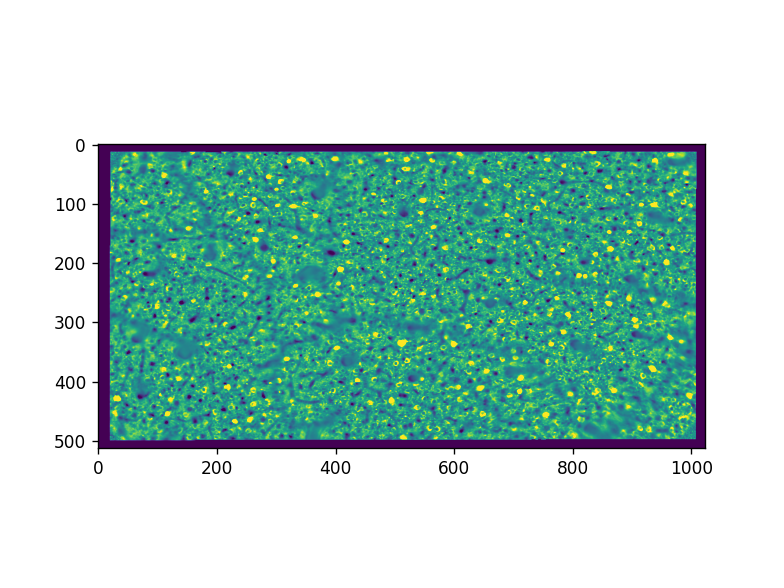

interactive(children=(IntSlider(value=0, description='i_frame', max=7), Output()), _dom_classes=('widget-inter…

In [19]:
%matplotlib notebook
from ipywidgets import *

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
imshow_FOV = ax.imshow(FOVs_aligned[0], vmax=230)

def update(i_frame = 0):
    fig.canvas.draw_idle()
    imshow_FOV.set_data(FOVs_aligned[i_frame])
    imshow_FOV.set_clim((0,230))


interact(update, i_frame=widgets.IntSlider(min=0, max=len(FOVs_aligned)-1, step=1, value=0));

In [20]:
# np.savez_compressed('/media/rich/bigSSD/analysis_data/mouse 2_6/multiday_alignment/ROIs_aligned2.npz', tuple(ROIs_aligned))

In [21]:
# ROIs_aligned = np.load('/media/rich/bigSSD/analysis_data/mouse 2_6/multiday_alignment/ROIs_aligned.npz', allow_pickle=True)['arr_0']

Get number of ROIs per FOV. Will be useful later for indexing stuff

In [25]:
n_roi_per_sesh = [sfs.shape[0] for sfs in ROIs_aligned]

n_roi_all = np.sum(n_roi_per_sesh)

Normalize

In [26]:
def make_block_batches(
    frame_height=512,
    frame_width=1024,
    block_height=100,
    block_width=100,
    overlapping_width_Multiplier=2,
    outer_block_height=None,
    outer_block_width=None,
    clamp_outer_block_to_frame=True,
):     
    
    # block prep
    block_height_half = block_height//2
    block_width_half = block_width//2
    
    # inner block prep
    if outer_block_height is None:
        outer_block_height = block_height * 1.5
        print(f'Outer block height not specified. Using {outer_block_height}')
    if outer_block_width is None:
        outer_block_width = block_width * 1.5
        print(f'Outer block width not specified. Using {outer_block_width}')
        
    outer_block_height_half = outer_block_height//2
    outer_block_width_half = outer_block_width//2
    
    # find centers of blocks
#     n_blocks_x = np.ceil((frame_width*overlapping_width_Multiplier) / block_width).astype(np.int64)
    n_blocks_x = np.ceil(frame_width / (block_width - (block_width*overlapping_width_Multiplier))).astype(np.int64)

    centers_x = np.linspace(
        start=block_width_half,
        stop=frame_width - block_width_half,
        num=n_blocks_x,
        endpoint=True
    )

#     n_blocks_y = frame_height / block_height
    n_blocks_y = np.ceil(frame_height / (block_height - (block_height*overlapping_width_Multiplier))).astype(np.int64)
#     n_blocks_y = np.ceil(n_blocks_y*overlapping_width_Multiplier).astype(np.int64)
    centers_y = np.linspace(
        start=block_height_half,
        stop=frame_height - block_height_half,
        num=n_blocks_y,
        endpoint=True
    )
    
#     print(n_blocks_x)
#     print(centers_x)
    
    # make blocks
    blocks, outer_blocks = [], []
    for i_x in range(n_blocks_x):
        for i_y in range(n_blocks_y):
            blocks.append([
                list(np.int64([centers_y[i_y] - block_height_half , centers_y[i_y] + block_height_half])),
                list(np.int64([centers_x[i_x] - block_width_half , centers_x[i_x] + block_width_half]))
            ])
            
            outer_blocks.append([
                list(np.int64([centers_y[i_y] - outer_block_height_half , centers_y[i_y] + outer_block_height_half])),
                list(np.int64([centers_x[i_x] - outer_block_width_half , centers_x[i_x] + outer_block_width_half]))                
            ])
            
    # clamp outer block to limits of frame
    if clamp_outer_block_to_frame:
        for ii, outer_block in enumerate(outer_blocks):
            br_h = np.array(outer_block[0]) # block range height
            br_w = np.array(outer_block[1]) # block range width
            valid_h = (br_h>0) * (br_h<frame_height)
            valid_w = (br_w>0) * (br_w<frame_width)
            outer_blocks[ii] = [
                list( (br_h * valid_h) + (np.array([0, frame_height])*np.logical_not(valid_h)) ),
                list( (br_w * valid_w) + (np.array([0, frame_width])*np.logical_not(valid_w)) ),            
            ]
        
    return blocks, outer_blocks, (centers_y, centers_x)

set parameters

In [27]:
frame_height=512
frame_width=1024
block_height=100
block_width=100
overlapping_width_Multiplier=0.0
outer_block_height=130
outer_block_width=130
clamp_outer_block_to_frame=True

inner_blocks, outer_blocks, centers = make_block_batches(
    frame_height=frame_height,
    frame_width=frame_width,
    block_height=block_height,
    block_width=block_width,
    overlapping_width_Multiplier=overlapping_width_Multiplier,
    outer_block_height=outer_block_height,
    outer_block_width=outer_block_width,
    clamp_outer_block_to_frame=clamp_outer_block_to_frame
)
n_blocks = len(inner_blocks)
display(inner_blocks)
display(outer_blocks)
print(n_blocks)

[[[0, 100], [0, 100]],
 [[82, 182], [0, 100]],
 [[164, 264], [0, 100]],
 [[247, 347], [0, 100]],
 [[329, 429], [0, 100]],
 [[412, 512], [0, 100]],
 [[0, 100], [92, 192]],
 [[82, 182], [92, 192]],
 [[164, 264], [92, 192]],
 [[247, 347], [92, 192]],
 [[329, 429], [92, 192]],
 [[412, 512], [92, 192]],
 [[0, 100], [184, 284]],
 [[82, 182], [184, 284]],
 [[164, 264], [184, 284]],
 [[247, 347], [184, 284]],
 [[329, 429], [184, 284]],
 [[412, 512], [184, 284]],
 [[0, 100], [277, 377]],
 [[82, 182], [277, 377]],
 [[164, 264], [277, 377]],
 [[247, 347], [277, 377]],
 [[329, 429], [277, 377]],
 [[412, 512], [277, 377]],
 [[0, 100], [369, 469]],
 [[82, 182], [369, 469]],
 [[164, 264], [369, 469]],
 [[247, 347], [369, 469]],
 [[329, 429], [369, 469]],
 [[412, 512], [369, 469]],
 [[0, 100], [462, 562]],
 [[82, 182], [462, 562]],
 [[164, 264], [462, 562]],
 [[247, 347], [462, 562]],
 [[329, 429], [462, 562]],
 [[412, 512], [462, 562]],
 [[0, 100], [554, 654]],
 [[82, 182], [554, 654]],
 [[164, 264],

[[[0, 115], [0, 115]],
 [[67, 197], [0, 115]],
 [[149, 279], [0, 115]],
 [[232, 362], [0, 115]],
 [[314, 444], [0, 115]],
 [[397, 512], [0, 115]],
 [[0, 115], [77, 207]],
 [[67, 197], [77, 207]],
 [[149, 279], [77, 207]],
 [[232, 362], [77, 207]],
 [[314, 444], [77, 207]],
 [[397, 512], [77, 207]],
 [[0, 115], [169, 299]],
 [[67, 197], [169, 299]],
 [[149, 279], [169, 299]],
 [[232, 362], [169, 299]],
 [[314, 444], [169, 299]],
 [[397, 512], [169, 299]],
 [[0, 115], [262, 392]],
 [[67, 197], [262, 392]],
 [[149, 279], [262, 392]],
 [[232, 362], [262, 392]],
 [[314, 444], [262, 392]],
 [[397, 512], [262, 392]],
 [[0, 115], [354, 484]],
 [[67, 197], [354, 484]],
 [[149, 279], [354, 484]],
 [[232, 362], [354, 484]],
 [[314, 444], [354, 484]],
 [[397, 512], [354, 484]],
 [[0, 115], [447, 577]],
 [[67, 197], [447, 577]],
 [[149, 279], [447, 577]],
 [[232, 362], [447, 577]],
 [[314, 444], [447, 577]],
 [[397, 512], [447, 577]],
 [[0, 115], [539, 669]],
 [[67, 197], [539, 669]],
 [[149, 279],

66


Main code block: \
computes matches across sessions for each block

In [28]:
######## CPU PARAMETERS ########
##### Ignore if using GPU ######
################################

NN_cpu = sklearn.neighbors.NearestNeighbors(
#         n_neighbors=100,  ## currently using min(sf_block_flat.shape[0], max_n_neighbors)
#     radius=1.0, 
    algorithm='auto',
    leaf_size=30, 
    metric='manhattan',
    p=1,
#     metric_params=None, 
    n_jobs=-1
)

tsne_cpu = sklearn.manifold.TSNE(
    n_components=2,
    perplexity=30.0,
    early_exaggeration=5.0,
    learning_rate='auto',
    n_iter=3000,
    n_iter_without_progress=300,
    min_grad_norm=1e-07,
    metric='precomputed',
    init='random',
    verbose=0,
    random_state=None,
    method='barnes_hut',
    angle=0.8,
    n_jobs=-1,
#     square_distances=True,
)



######## GPU PARAMETERS ########
##### Ignore if using CPU ######
################################

NN_gpu = cuml.neighbors.NearestNeighbors(
#         n_neighbors=100,  ## currently using min(sf_block_flat_scaled.shape[0], max_n_neighbors)
        verbose=True, 
        metric='manhattan', 
        output_type='numpy', 
    )

tsne_gpu = cuml.manifold.TSNE(
    n_components=2,
    perplexity=30.0,
    early_exaggeration=12.0,
    learning_rate=400.0,
    n_iter=1000,
    n_iter_without_progress=300,
    min_grad_norm=1e-07,
#     metric='Euclidean',
    init='random',
    verbose=False,
    random_state=None,
    method='exact',
    angle=0.8,
    square_distances=False,
    learning_rate_method='none',
#     n_neighbors=None,
    perplexity_max_iter=100,
    exaggeration_iter=250,
    pre_momentum=0.5,
    post_momentum=0.8,
    handle=None,
    output_type='numpy',
)

In [29]:
#### IMPORTANT PARAMETER: K-NEAREST NEIGHBORS ####
## Lower this to improve speed, but sacrifice some quality. 
## Choose a number that is > ~ the largest number of ROIs you think a single ROI might have any overlap with.
## For most datasets, values around 200 should give high quality results.
## Max value is 1023.
## Value must be > 3*perplexity.

max_n_neighbors = 200

##################################################


####### Other Parameters #######

## This parameter determines how 'binary'-looking masks are
## Small values = more binary. Large values weight bright pixels more
## mask_scaled = mask ** mask_power
mask_power = 0.3



pref_use_GPU = True

if pref_use_GPU:
    NN = NN_gpu
    tsne = tsne_gpu
else:
    NN = NN_cpu
    tsne = tsne_cpu

In [30]:
idx_roi_cat = np.concatenate([np.arange(sfs.shape[0]) for sfs in ROIs_aligned]) # indices of each ROI concatenated together
idx_roi_session = np.concatenate([np.ones(sfs.shape[0])*ii for ii,sfs in enumerate(ROIs_aligned)])

block_rois = []
# for ii, block in enumerate(tqdm([outer_blocks[0]])):
# for ii, block in enumerate(tqdm(outer_blocks)):
for i_block in tqdm(range(n_blocks)):
    ## Get indices of ROIs in outer and inner blocks
    def get_ROI_idx_from_block_idx(block, spatial_footprints_flat, frame_height=512, frame_width=1024):
        """
        This function:
         1. gets the indices of all the pixels in the block (return: idx_block)
         2. crops each spatial footprint image (size frame_height x frame_width) to just 
            the block pixels (return: sf_block_allSesh)
         3. finds the ROIs that are within the block and makes boolean and index output arrays listing them.
            Outputs:
             a. bool_ROI_inBlock_allSesh: a list where each entry is a session and each element is a boolean
                array listing whether that ROI is in the block
             b. idx_ROI_inBlock_allSesh: a list where each entry is a session and each element is the index
                of an ROI that is in the block
             c. boolCat_ROI_inBlock: an array listing which ROIs across all sessions that are in the block
             d. idxCat_ROI_inBlock: an array listing the indices of ROIs across all sessions that are in 
                the block
        """
        idx_block = np.reshape(
            np.ravel_multi_index(
                np.meshgrid(np.arange(block[0][0], block[0][1]), np.arange(block[1][0], block[1][1])),
                (frame_height, frame_width),
                order='C'),
            newshape=-1,
            order='F')

        sf_block_allSesh         = [sfs[:,idx_block] for sfs in spatial_footprints_flat]
        bool_ROI_inBlock_allSesh = [np.array(sfs.sum(1) > 0).squeeze() for sfs in sf_block_allSesh]
        idx_ROI_inBlock_allSesh  = [np.where(bool_ROI)[0] for bool_ROI in bool_ROI_inBlock_allSesh]

        boolCat_ROI_inBlock = np.concatenate(bool_ROI_inBlock_allSesh)
        idxCat_ROI_inBlock = np.where(boolCat_ROI_inBlock)[0]
        
        return idx_block, bool_ROI_inBlock_allSesh, idx_ROI_inBlock_allSesh, boolCat_ROI_inBlock, idxCat_ROI_inBlock, sf_block_allSesh
    
    idx_outer_block, bool_ROI_inOuterBlock_allSesh, idx_ROI_inOuterBlock_allSesh, boolCat_ROI_inOuterBlock, idxCat_ROI_inOuterBlock, sf_OuterBlock_allSesh = \
        get_ROI_idx_from_block_idx(
            block=outer_blocks[i_block], 
            spatial_footprints_flat=ROIs_aligned, 
            frame_height=512, 
            frame_width=1024
        )
        
    idx_inner_block, bool_ROI_inInnerBlock_allSesh, idx_ROI_inInnerBlock_allSesh, boolCat_ROI_inInnerBlock, idxCat_ROI_inInnerBlock, sf_InnerBlock_allSesh = \
        get_ROI_idx_from_block_idx(
            block=outer_blocks[i_block], 
            spatial_footprints_flat=ROIs_aligned, 
            frame_height=512, 
            frame_width=1024
        )

    
    sf_block_inROIs_allSesh      = [sfs[idx_ROI_inOuterBlock_allSesh[ii],:] for ii,sfs in enumerate(sf_OuterBlock_allSesh)]
    sf_block_flat        = scipy.sparse.vstack([sfs for sfs in sf_block_inROIs_allSesh])
    sf_block_flat_scaled = sf_block_flat.power(mask_power)
    sf_block_flat_scaled = sf_block_flat_scaled.multiply( 0.5 / sf_block_flat_scaled.sum(1)) # this scaling makes each ROI sum to 0.5, so the max distance between two ROIs is 1
    sf_block_flat_scaled = scipy.sparse.csr_matrix(sf_block_flat_scaled)
    
    
    
    n_neighbors = min(sf_block_flat_scaled.shape[0], max_n_neighbors)
#     print(f'Using n_neighbors: {n_neighbors}')

    distances = NN.fit(sf_block_flat_scaled).kneighbors_graph(
        sf_block_flat_scaled,
        n_neighbors=n_neighbors,
        mode='distance'
    )
#     distances[distances>=0.99] = 100
    
    tsne.n_neighbors = n_neighbors
    if pref_use_GPU:
        embeddings = tsne.fit_transform(
            X=sf_block_flat_scaled,
            knn_graph=distances.power(2)
        )
    else:
        embeddings = tsne.fit_transform(
            X=distances,
        )


    block_rois.append({

        "idx_outer_block": idx_outer_block,
        "idx_inner_block": idx_inner_block,
        
        "bool_ROI_inOuterBlock_allSesh": bool_ROI_inOuterBlock_allSesh, # shape: (list len n_blocks (n_roi per block)). value: whether that roi is in the outer block
        "idx_ROI_inOuterBlock_allSesh" :  idx_ROI_inOuterBlock_allSesh, # shape: (list len n_blocks (n_roi in outer block)). value: indices of rois in the outer block
        "boolCat_ROI_inOuterBlock": boolCat_ROI_inOuterBlock, # shape: (n_roi across sessions). value: whether that roi is in the outer block
        "idxCat_ROI_inOuterBlock": idxCat_ROI_inOuterBlock, # shape: (n_roi in the outer block across all sessions). value: indices of the rois in the outer block
        
        "bool_ROI_inInnerBlock_allSesh": bool_ROI_inInnerBlock_allSesh, # shape: (list len n_blocks (n_roi per block)). value: whether that roi is in the inner block
        "idx_ROI_inInnerBlock_allSesh" :  idx_ROI_inInnerBlock_allSesh, # shape: (list len n_blocks (n_roi in inner block)). value: indices of rois in the inner block
        "boolCat_ROI_inInnerBlock": boolCat_ROI_inInnerBlock, # shape: (n_roi across sessions). value: whether that roi is in the inner block
        "idxCat_ROI_inInnerBlock": idxCat_ROI_inInnerBlock, # shape: (n_roi in the inner block across all sessions). value: indices of the rois in the inner block
        
        "n_neighbors": n_neighbors,
        "distances": distances,
        "tsne": tsne,
        "embeddings": embeddings,
    })

  0%|          | 0/66 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


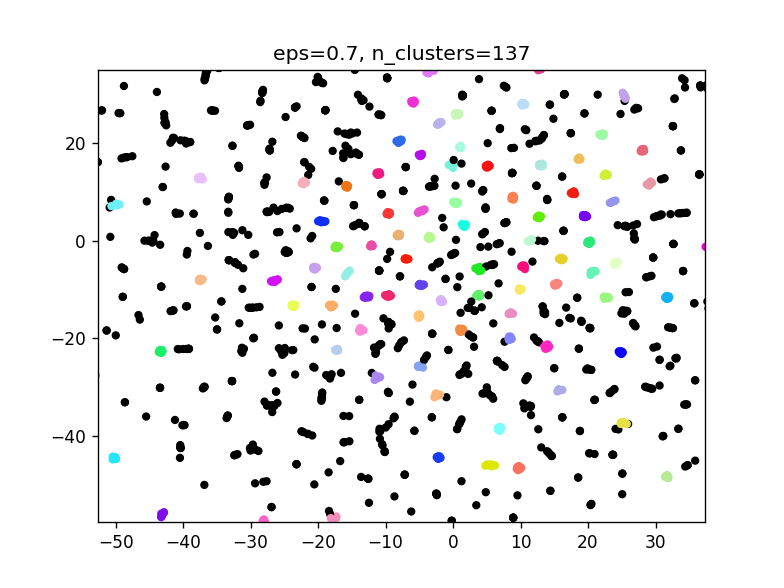

interactive(children=(IntSlider(value=100, description='eps', max=400, min=100), Output()), _dom_classes=('wid…

In [32]:
%matplotlib notebook
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

block_toUse = 32

# db = block_rois[block_toUse]['db']
embeddings = block_rois[block_toUse]['embeddings']
# embeddings = embeddings

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
sc = ax.scatter(embeddings[:,0], embeddings[:,1], s=15)
# sc = ax.scatter(embeddings2[:,0], embeddings2[:,1], embeddings2[:,2], s=15)

def update(eps = 1.0):
    eps_toUse = (eps/200)**2
    # Compute DBSCAN
    db = sklearn.cluster.DBSCAN(
        eps=eps_toUse,
        min_samples=7, 
#         metric='manhattan',
        metric_params=None, 
        algorithm='auto',
        leaf_size=30, 
        p=2, 
        n_jobs=-1
    ).fit(embeddings)

    cmap = plotting_helpers.rand_cmap(db.labels_.max(), verbose=False)

    sc.set_color(cmap(db.labels_))

    fig.canvas.draw_idle()
    ax.set_title(f'eps={round(eps_toUse,1)}, n_clusters={db.labels_.max()}')

interact(update, eps=widgets.IntSlider(min=100, max=400, step=1, value=100));

set parameters for clustering

In [33]:
dbscan = sklearn.cluster.DBSCAN(
        eps=0.7,
        min_samples=3, 
#         metric='manhattan',
        metric_params=None, 
        algorithm='auto',
        leaf_size=30, 
        p=2, 
        n_jobs=-1
    )

In [34]:
def is_unique(vals):
    is_unique = len(vals) == len(np.unique(vals))
    return is_unique

In [35]:
for ii, block in enumerate(tqdm(block_rois)):
    ## DBSCAN
    db = copy.copy(dbscan)
    db.fit(block['embeddings']) # note that db.labels_==-1 means no cluster found
    
    block_rois[ii]['db'] = db
    block_rois[ii]['labels_unique'] = np.unique(block['db'].labels_)
    block_rois[ii]['cluster_sessions'] = [idx_roi_session[block['idxCat_ROI_inOuterBlock'][block['db'].labels_==label]] for label in block['labels_unique']] # list of sessions a unique label derives from. Shape: [n_unique_labels][num of sessions where label is found]
    block_rois[ii]['cluster_sessions_isUnique'] = np.array([is_unique(sessions) for sessions in block['cluster_sessions']]) # boolean. Shape (n_labels_unique). Value whether all the labels derive from unique sessions.
    

  0%|          | 0/66 [00:00<?, ?it/s]

In [36]:
pickle_helpers.simple_save(block_rois, '/media/rich/bigSSD/analysis_data/mouse 2_6/multiday_alignment/block_rois5.pkl')

In [37]:
# block_rois = pickle_helpers.simple_load('/media/rich/bigSSD/analysis_data/mouse 2_6/multiday_alignment/block_rois.pkl')

the following block should be able to get folded into the main loop above. Just need to break the list comprehension up into a real for loop and index into both the inner and outer blocks

In [38]:
bool_roi_outerBlock_cat = np.stack([block['boolCat_ROI_inOuterBlock'] for block in block_rois])
bool_roi_innerBlock_cat = np.stack([block['boolCat_ROI_inInnerBlock'] for block in block_rois])

In [39]:
# ## Process inner block (ROI idx ownership)
# idx_roi_inInnerBlock = []
# for ii, block in enumerate(tqdm(blocks)):
#     sf_block_cat = np.concatenate([sfs.toarray().reshape(sfs.shape[0], frame_height, frame_width)[:,block[0][0]:block[0][1], block[1][0]:block[1][1]] for sfs in ROIs_aligned], axis=0) # cropped spatial footprints. shape=(n_rois across all sessions, inner_block_height, inner_block_width)
#     idx_outOfInnerBlock = np.sum(sf_block_cat, axis=(1,2)) == 0 # roi idx bool that have no pixels in the current block
#     idx_roi_inInnerBlock.append(idx_outOfInnerBlock==False) # roi idx bool that have any pixels in the current block
    

## Get ROI properties
1. Cluster size (n_roi in cluster)
2. Cluster mean of distances (mean of differences between spatial footprints)
3. Cluster std of distances (variance of differences between spatial footprints)
4. Cluster max of distances (max of differences between spatial footprints)

Heuristic to determine which block to trust for each ROI:

- for each block, determine how many rois are a part of each cluster
- for each roi, determine how many 'neighbor' rois are in it's cluster


- then, for each roi, trust the block that clustered it with the greatest number of ROIs that wasn't too many (ranges between a user defined range)

### 1. Cluster size

Get sizes of each cluster

In [40]:
unique_cluster_ids = [block['labels_unique'] for block in block_rois]
sizes_clusters = [ [(block['db'].labels_==cid).sum() for cid in unique_cluster_ids[i_block]] for i_block, block in enumerate(block_rois) ]

### 2. Clusters from unique sessions

In [41]:
clusters_fromUniqueSessions = [block['cluster_sessions_isUnique'] for block in block_rois]

### 3-5. Distance statistics

User settings

In [42]:
######## CPU PARAMETERS ########
##### Ignore if using GPU ######
################################

NN_cpu = sklearn.neighbors.NearestNeighbors(
#         n_neighbors=100,  ## currently using min(sf_block_flat.shape[0], max_n_neighbors)
#     radius=1.0, 
    algorithm='auto',
    leaf_size=30, 
    metric='manhattan',
    p=1,
#     metric_params=None, 
    n_jobs=-1
)

######## GPU PARAMETERS ########
##### Ignore if using CPU ######
################################

NN_gpu = cuml.neighbors.NearestNeighbors(
#         n_neighbors=100,  ## currently using min(sf_block_flat_scaled.shape[0], max_n_neighbors)
        verbose=True, 
        metric='manhattan', 
        output_type='numpy', 
    )

In [43]:
pref_use_GPU = True

if pref_use_GPU:
    NN = NN_gpu
    tsne = tsne_gpu
else:
    NN = NN_cpu
    tsne = tsne_cpu

In [44]:
mask_power = mask_power

Calculate feature distances for ROIs within each cluster

In [45]:
ROIs_aligned_cat = scipy.sparse.vstack(ROIs_aligned)
ROIs_aligned_cat_scaled = ROIs_aligned_cat
ROIs_aligned_cat_scaled = ROIs_aligned_cat_scaled.power(mask_power)
ROIs_aligned_cat_scaled = ROIs_aligned_cat_scaled.multiply( 1 / ROIs_aligned_cat_scaled.sum(1) )
ROIs_aligned_cat_scaled = scipy.sparse.csr_matrix(ROIs_aligned_cat_scaled)

distances_clusters = [[]]*len(block_rois)
for i_block, block in enumerate(tqdm(block_rois)):
    labels = block['db'].labels_
    uci = unique_cluster_ids[i_block]
    distances_clusters[i_block] = [[]]*len(uci)
    for i_cid, cid in enumerate(uci):
        roi_idx_cluster = np.where(labels == cid)[0]
        roi_idx = block['idxCat_ROI_inOuterBlock'][roi_idx_cluster]
        features = ROIs_aligned_cat_scaled[roi_idx]
        
        n_neighbors = features.shape[0]
        distances = NN.fit(features).kneighbors_graph(
            features,
            n_neighbors=n_neighbors,
            mode='distance'
        )
        distances_clusters[i_block][i_cid] = distances
              

## Calculate statistics of distance matrices
fn_dist_mean = lambda x: np.mean(x[np.triu_indices(x.shape[0], k=1)])
fn_dist_std = lambda x: np.std(x[np.triu_indices(x.shape[0], k=1)])
fn_dist_max = lambda x: np.max(x[np.triu_indices(x.shape[0], k=1)])

dist_mean_all = [ [fn_dist_mean(distances_clusters[i_block][ii].toarray()) for ii in range(len(distances_clusters[i_block]))] for i_block in range(len(distances_clusters)) ]
dist_std_all  = [ [fn_dist_std(distances_clusters[i_block][ii].toarray())  for ii in range(len(distances_clusters[i_block]))] for i_block in range(len(distances_clusters)) ]
dist_max_all  = [ [fn_dist_max(distances_clusters[i_block][ii].toarray())  for ii in range(len(distances_clusters[i_block]))] for i_block in range(len(distances_clusters)) ]

  0%|          | 0/66 [00:00<?, ?it/s]

Plots for distance metrics

<IPython.core.display.Javascript object>


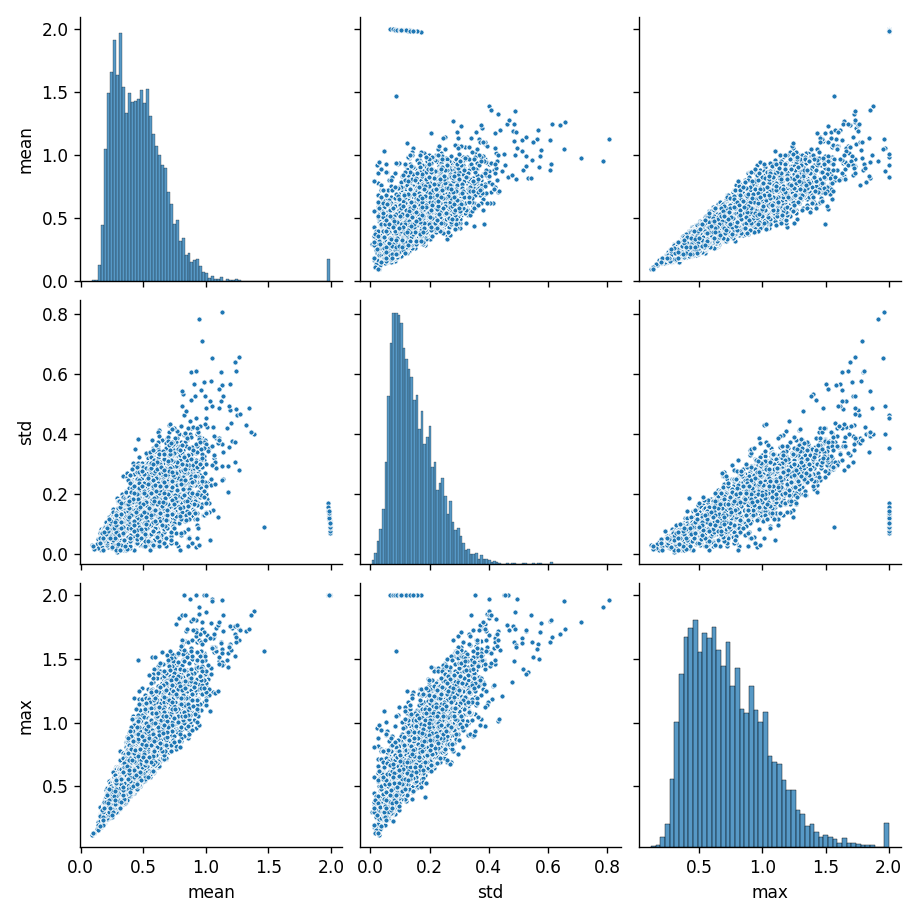

In [46]:
dist_mean_all_cat = np.concatenate(dist_mean_all)
dist_std_all_cat  = np.concatenate(dist_std_all)
dist_max_all_cat  = np.concatenate(dist_max_all)

pair_columns = pd.DataFrame({
    "mean": dist_mean_all_cat,
    "std": dist_std_all_cat,
    "max": dist_max_all_cat,
})
# plt.figure()
sns.pairplot(pair_columns, markers='.')

Set inclusion thresholds

In [82]:
cluster_properites = {
    "n_roi": sizes_clusters,
    "clusters_fromUniqueSessions": clusters_fromUniqueSessions,
    "cluster_distance_mean": dist_mean_all,
    "cluster_distance_std": dist_std_all,
    "cluster_distance_max": dist_std_all,
}

cluster_inclusion_criteria_ranges = {
    "n_roi": (8,8),
    "clusters_fromUniqueSessions": (True,True),
    "cluster_distance_mean": (0,1),
    "cluster_distance_std": (0,0.4),
    "cluster_distance_max": (0,1.8),
}

Assign cluster scores by inner blocks to each ROI. \
output (roi_cluster_properties) is a dictionary. 1 entry for each property. entry shape: (n_blocks, n_roi)

In [83]:
n_blocks = len(block_rois)
n_properties = len(cluster_properites)

# roi_labelFreqs = np.ones((len(block_rois), n_roi_all)) * np.nan # shape (n_blocks, n_roi_total)
roi_cluster_properties = {key: np.ones((n_blocks, n_roi_all)) * np.nan for key,val in cluster_properites.items()}

for i_block, block in enumerate(tqdm(block_rois)):
    labels = block['db'].labels_
    labels_unique = np.unique(labels)
#     label_sizes = [list(labels).count(label) for label in labels_unique]
    
    bool_outer = block_rois[i_block]['boolCat_ROI_inOuterBlock']
    idx_outer  = block_rois[i_block]['idxCat_ROI_inOuterBlock']
    
    bool_inner = np.concatenate(block_rois[i_block]['bool_ROI_inInnerBlock_allSesh'])
    idx_inner = np.where(bool_inner)[0]
    
    for i_roi in range(n_roi_all): # for every ROI
        if i_roi in idx_outer: # check if roi was in the outer frame
            
            if i_roi in idx_inner: # check if roi was in the inner frame
                arg_outer = np.where(i_roi == idx_outer) # get argument in outer list of this roi
                label = labels[arg_outer] # get the label of this roi in this block
                arg_unique = np.where(labels_unique == label)[0][0] # get the idx/arg of of the labels_unique label
                
                
                for i_property, (key, val) in enumerate(cluster_properites.items()):
                    roi_cluster_properties[key][i_block, i_roi] = val[i_block][arg_unique]
#                     print(val[i_block][arg_unique])
#                     print(roi_cluster_properties[key][i_block, i_roi])
                    roi_cluster_properties

  0%|          | 0/66 [00:00<?, ?it/s]

In [84]:
def bool_in_range(array, range_vals):
    return (array >= range_vals[0]) * (array <= range_vals[1])

In [85]:
roi_cluster_inclusion_allProperties = {key: bool_in_range(roi_cluster_properties[key], cluster_inclusion_criteria_ranges[key]) for key,val in roi_cluster_properties.items()}
roi_cluster_inclusion = np.stack(tuple(roi_cluster_inclusion_allProperties.values())).prod(0)

<IPython.core.display.Javascript object>


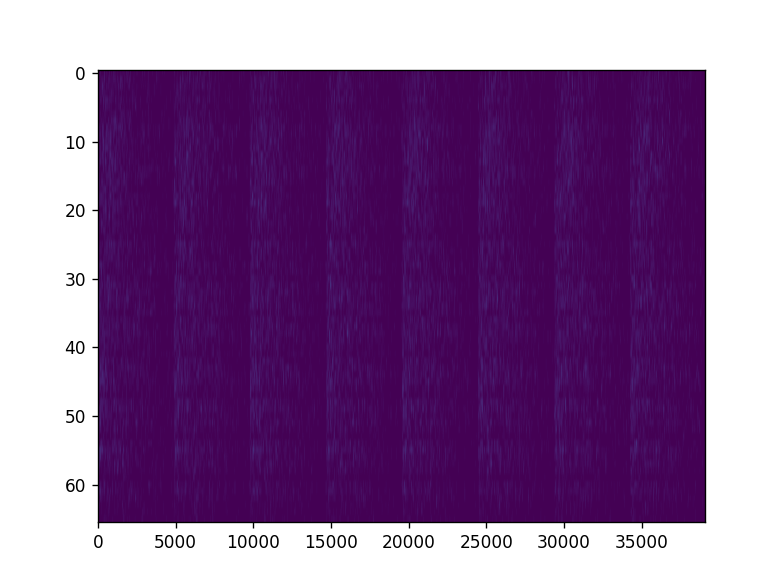

In [86]:
plt.figure()
plt.imshow(roi_cluster_inclusion, aspect='auto')

- randomly choose rois from a list of all eligible ROIs
- randomly choose a block that meet criteria for that roi,
- find what other rois are a part of the cluster that it's in
    - find what it's cluster label is for that block
    - find other rois with that cluster label
- assign that roi and all of the rois in that cluster a UCID
- remove all those rois from the list to choose from

In [87]:
UCIDs_rough = np.ones(n_roi_all, dtype=np.int64) * -1
rois_included = np.where(roi_cluster_inclusion.sum(0) > 0)[0]
list_eligible = copy.copy(rois_included)
ucid_new = 0
bunch_of_nans = np.ones(len(UCIDs_rough))*np.nan
UCID_properties = {
    'block':                 copy.copy(bunch_of_nans),
    'idx_in_outerBlock':     copy.copy(bunch_of_nans),
    'label_in_outerBlock':   copy.copy(bunch_of_nans),
    "n_roi_in_Cluster":      copy.copy(bunch_of_nans),
    "cluster_distance_mean": copy.copy(bunch_of_nans),
    "cluster_distance_std":  copy.copy(bunch_of_nans),
    "cluster_distance_max":  copy.copy(bunch_of_nans),
    "session":               idx_roi_session,
}
while len(list_eligible) > 0: # while there are still values that have not been deleted
    idx_inList = random.choice(list_eligible)
#     idx_inList = list_eligible[0]
    block_toUse = random.choice(np.where(roi_cluster_inclusion[:,idx_inList] > 0)[0])
    idx_in_block = np.where(block_rois[block_toUse]['idxCat_ROI_inOuterBlock'] == idx_inList)[0]
    label = block_rois[block_toUse]['db'].labels_[idx_in_block]
    idx_others_in_block = np.where(block_rois[block_toUse]['db'].labels_ == label)[0]
    idx_others = block_rois[block_toUse]['idxCat_ROI_inOuterBlock'][idx_others_in_block]
    
    if np.sum(np.isin(idx_others, np.where(UCIDs_rough>=0)[0]) > 0):
        list_eligible = np.delete(list_eligible, np.where(np.isin(list_eligible, idx_inList))[0])
        continue
    
    UCIDs_rough[idx_others] = ucid_new
    ucid_new += 1
    
    list_eligible = np.delete(list_eligible, np.where(np.isin(list_eligible, idx_others))[0])
    
    
    UCID_properties['block'][idx_others] = block_toUse
    UCID_properties['idx_in_outerBlock'][idx_others] = idx_others_in_block
    UCID_properties['label_in_outerBlock'][idx_others] = label
    UCID_properties['n_roi_in_Cluster'][idx_others] = roi_cluster_properties['n_roi'][block_toUse][idx_others]
    UCID_properties['cluster_distance_mean'][idx_others] = roi_cluster_properties['cluster_distance_mean'][block_toUse][idx_others]
    UCID_properties['cluster_distance_std'][idx_others] = roi_cluster_properties['cluster_distance_std'][block_toUse][idx_others]
    UCID_properties['cluster_distance_max'][idx_others] = roi_cluster_properties['cluster_distance_max'][block_toUse][idx_others]

In [88]:
UCIDs = UCIDs_rough

<IPython.core.display.Javascript object>


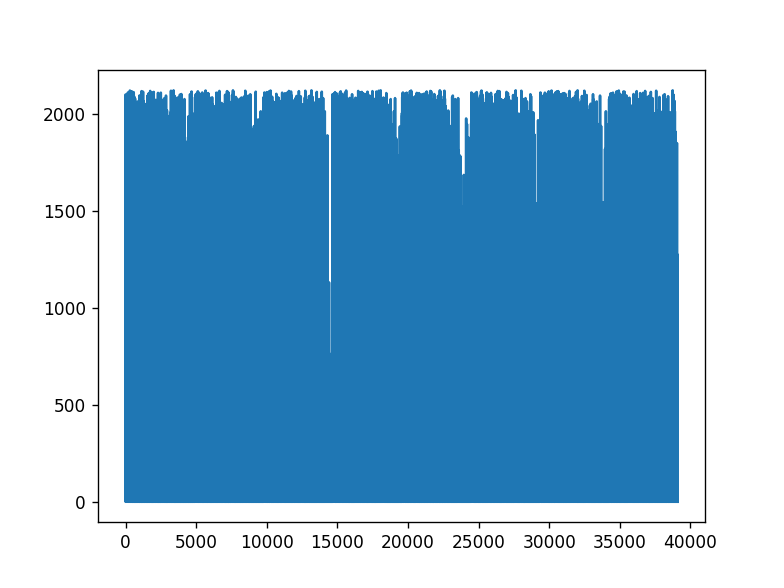

In [89]:
plt.figure()
plt.plot(UCIDs_rough)

In [90]:
def values_with_counts_outside_of_range(values, val_range, verbose=True):
    unique_values = np.unique(values)
    unique_counts = np.array([np.sum(values==val) for val in unique_values])
    bad_outOfRange = unique_values[
        np.logical_not(np.isin(
            unique_counts,
                np.arange(val_range[0], val_range[1]+1)
        ))
    ]
    print(f'Found bad values: {bad_outOfRange}')
    return bad_outOfRange

In [91]:
np.sum(UCIDs_rough>=0)

16968

In [92]:
len(np.unique(UCIDs_rough))

2122

In [93]:
bad_UCIDs = values_with_counts_outside_of_range(UCIDs_rough, cluster_inclusion_criteria_ranges['n_roi'])
UCIDs = copy.copy(UCIDs_rough)
UCIDs[np.isin(UCIDs, bad_UCIDs)] = -1
UCIDs = classification.squeeze_integers(UCIDs)
UCID_properties['UCID'] = UCIDs
values_with_counts_outside_of_range(UCIDs, cluster_inclusion_criteria_ranges['n_roi']);

Found bad values: [-1]
Found bad values: [-1]


In [94]:
unique_UCIDs = np.unique(UCIDs)

In [95]:
n_sessions = len(ROIs_aligned)
n_roi_per_sesh
bounds_idx_roi_per_sesh = np.concatenate([[0], np.cumsum(n_roi_per_sesh)])
UCIDs_bySession = [UCIDs[bounds_idx_roi_per_sesh[ii]:bounds_idx_roi_per_sesh[ii+1]+100] for ii in range(n_sessions)]

In [96]:
# make a UCID x session matrix (boolean)
UCIDs_inSession = np.array([np.isin(unique_UCIDs, UCIDs_bySession[i_sesh]) for i_sesh in range(n_sessions)])
if np.sum(UCIDs_inSession==0):
    print(f'WARNING: Make sure you are okay with the fact that there are sessions where clusters are not present')
if np.sum(UCIDs_inSession>1):
    print(f'WARNING: Make sure you are okay with the fact that there are sessions where a single cluster has more than ROI in it')

# Unique clusters image
make an animation loop of an entire FOV looping through each session with all the ROIs. \
Each ROI in a cluster is given a distinct cluster color

In [97]:
ucid_toUse = unique_UCIDs[unique_UCIDs>0]

FOV_all = []
chunk_size = np.array([3, n_sessions, frame_height, frame_width]).prod()
ROIs_csr = scipy.sparse.csr_matrix(scipy.sparse.vstack(ROIs_aligned))
for ii, ucid in enumerate(tqdm(ucid_toUse)):
    rand_colors = np.random.rand(3)
    colors = rand_colors / rand_colors.max()

    idx_roi_ucid = np.where(UCIDs == ucid)[0]
    n_ucid = len(idx_roi_ucid)
    im_FOV_flat = ROIs_csr[idx_roi_ucid]
    im_FOV_flat_scaled = im_FOV_flat.multiply(1 / im_FOV_flat.max(1).toarray())
    im_FOV_flat_scaled_tiled_color = scipy.sparse.vstack([im_FOV_flat_scaled.multiply(colors[ii]) for ii in range(3)]).reshape((1, -1))

    FOV_all.append(im_FOV_flat_scaled_tiled_color)

FOV_all_sparseCOO = sparse.COO(scipy.sparse.vstack(FOV_all)).reshape((len(ucid_toUse), 3, n_sessions, frame_height, frame_width))

FOV_all_sparseCOO_flat = FOV_all_sparseCOO.sum(0).transpose((1,2,3,0))

FOV_all = FOV_all_sparseCOO_flat.todense()

  0%|          | 0/2120 [00:00<?, ?it/s]

In [98]:
FOV_all_noClip = copy.copy(FOV_all)
FOV_all_noClip[FOV_all_noClip>1] = 1

In [99]:
plotting_helpers.play_video_cv2(FOV_all_noClip*255, frameRate=3, 
                                save_path='/home/rich/Desktop/test.avi'
                           )

saving to file /home/rich/Desktop/test.avi
Video saved


<IPython.core.display.Javascript object>


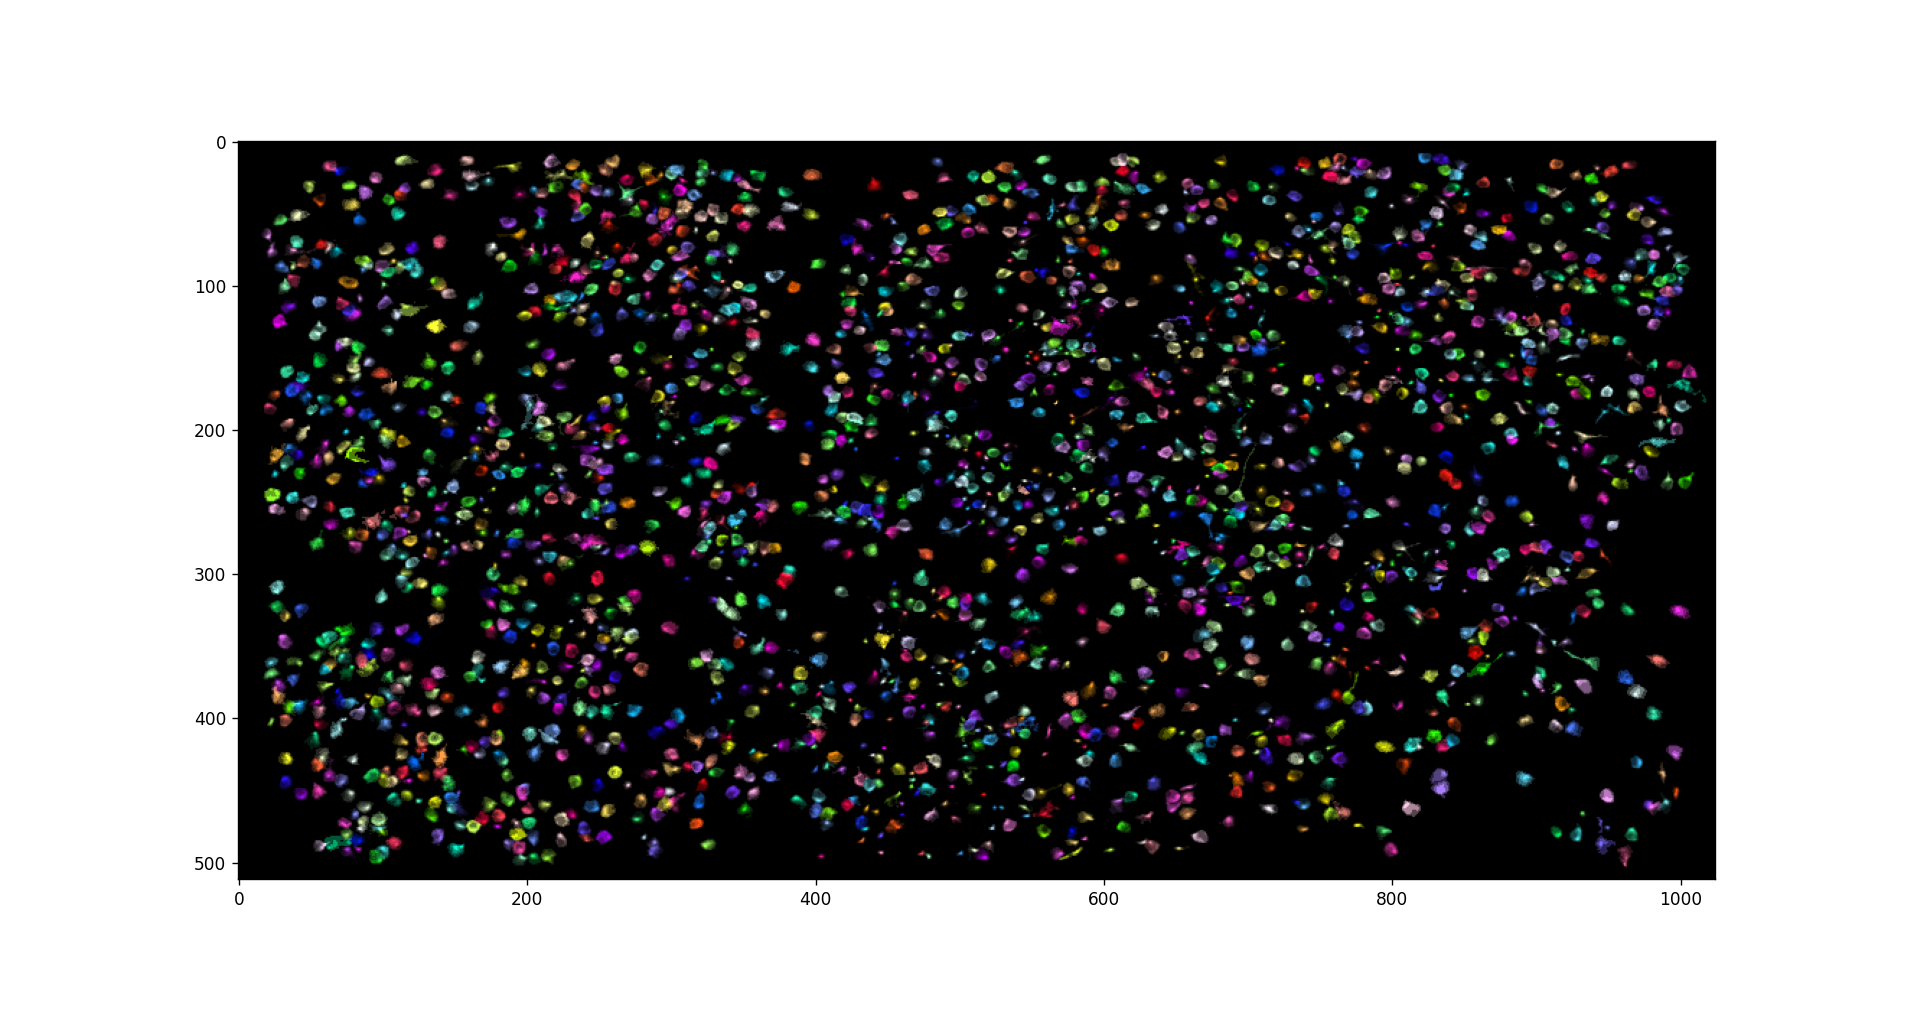

interactive(children=(IntSlider(value=0, description='i_frame', max=7), Output()), _dom_classes=('widget-inter…

In [100]:
%matplotlib notebook
from ipywidgets import *

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
imshow_FOV = ax.imshow(FOV_all_noClip[0])

def update(i_frame = 0):
    fig.canvas.draw_idle()
    imshow_FOV.set_data(FOV_all_noClip[i_frame])


interact(update, i_frame=widgets.IntSlider(min=0, max=FOV_all.shape[0]-1, step=1, value=0));

# Colored clusters image
make an animation loop of an entire FOV looping through each session with all the ROIs. \
Each ROI in a cluster is given a distinct cluster color

In [101]:
print('Available properties to use as colormap:')
display(list(UCID_properties.keys()))

Available properties to use as colormap:


['block',
 'idx_in_outerBlock',
 'label_in_outerBlock',
 'n_roi_in_Cluster',
 'cluster_distance_mean',
 'cluster_distance_std',
 'cluster_distance_max',
 'session',
 'UCID']

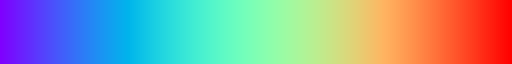

In [102]:
plt.get_cmap('rainbow')

In [103]:
ucid_toUse = unique_UCIDs[unique_UCIDs>0]
cmap_property = 'cluster_distance_std'

vals_property = UCID_properties[cmap_property]
vals_property_ranged = timeSeries.scale_between(vals_property, lower=0, upper=1.1, verbose=False)


cmaps = np.array([plt.get_cmap('rainbow')(ii) for ii in vals_property_ranged])[:,:3]

FOV_all = []
chunk_size = np.array([3, n_sessions, frame_height, frame_width]).prod()
ROIs_csr = scipy.sparse.csr_matrix(scipy.sparse.vstack(ROIs_aligned))
for ii, ucid in enumerate(tqdm(ucid_toUse)):
   
    idx_roi_ucid = np.where(UCIDs == ucid)[0]
    colors = cmaps[idx_roi_ucid]
    
    n_ucid = len(idx_roi_ucid)
    ROIs_scaled = ROIs_csr[idx_roi_ucid].multiply( 1 / ROIs_csr[idx_roi_ucid].max())
    im_FOV_flat_tiled_color = scipy.sparse.vstack([ROIs_scaled.multiply(cmaps[idx_roi_ucid, i_color][:,None]) for i_color in range(3)])
#     im_FOV_flat = ROIs_csr[idx_roi_ucid]
#     im_FOV_flat = scipy.sparse.csr_matrix(scipy.sparse.vstack([ROIs_csr[ii] for ii in idx_roi_ucid]))
#     im_FOV_flat_scaled = im_FOV_flat_tiled_color.multiply(1 / im_FOV_flat_tiled_color.max(1).toarray())
    im_FOV_vector = im_FOV_flat_tiled_color.reshape((1,-1))
#     im_FOV_flat_scaled_tiled_color = scipy.sparse.vstack([im_FOV_flat_scaled.multiply(colors[ii]) for ii in range(3)]).reshape((1, -1))
#     im_FOV_flat_scaled_tiled_color = scipy.sparse.vstack([im_FOV_flat_scaled for ii in range(3)]).reshape((1, -1))

    FOV_all.append(im_FOV_vector)

FOV_all_sparseCOO = sparse.COO(scipy.sparse.vstack(FOV_all)).reshape((len(ucid_toUse), 3, n_sessions, frame_height, frame_width))

FOV_all_sparseCOO_flat = FOV_all_sparseCOO.sum(0).transpose((1,2,3,0))

FOV_all = FOV_all_sparseCOO_flat.todense()

  0%|          | 0/2120 [00:00<?, ?it/s]

In [104]:
FOV_all_noClip = copy.copy(FOV_all)
FOV_all_noClip[FOV_all_noClip>1] = 1

In [105]:
plotting_helpers.play_video_cv2(FOV_all_noClip*255, frameRate=3, 
#                                 save_path='/home/rich/Desktop/test.avi'
                           )

<IPython.core.display.Javascript object>


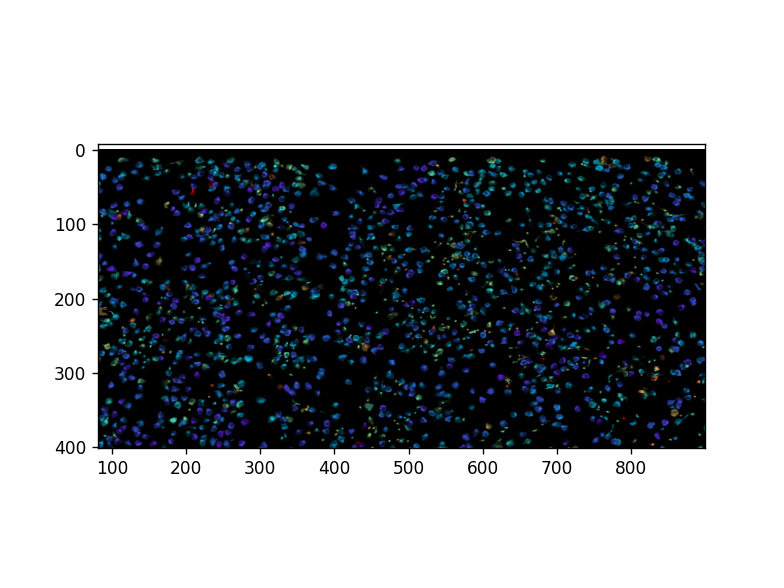

interactive(children=(IntSlider(value=0, description='i_frame', max=7), Output()), _dom_classes=('widget-inter…

In [106]:
%matplotlib notebook
from ipywidgets import *

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
imshow_FOV = ax.imshow(FOV_all_noClip[0])

def update(i_frame = 0):
    fig.canvas.draw_idle()
    imshow_FOV.set_data(FOV_all_noClip[i_frame])


interact(update, i_frame=widgets.IntSlider(min=0, max=FOV_all.shape[0]-1, step=1, value=0));